# Why Are Customers Churning?

**Quick Reference**

1. Project Plan
3. Imports
2. Acquire
3. Prep
4. Exploratory Data Analysis (EDA)
5. Models
6. Model Evaluation
7. Final Conclusions

# Project Plan

**Summary**

The Senior Leading Team wants to find out why our customers are churning.

Below is a list of questions they would like answered:

1. Are there clear groupings where a customer is more likely to churn? What if you consider contract type? Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers? 2-year customers? Do you have any thoughts on what could be going on? (Be sure to state these thoughts not as facts but as untested hypotheses. Unless you test them!). Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).
2. Are there features that indicate a higher propensity to churn? like type of Internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

**Goals**

The goals of this project are to answer the above questions and to deliver our findings in the following formats:

1. Report with detailed analysis in .ipynb format
2. CSV file containing customer_id, probability of churn, and the prediction of churn (1=churn, 0=not_churn)
3. Google Slides explaining model chosen and brief analysis for SLT
4. All files necessary to recreate our findings and models
5. Readme file
6. GitHub repo containing all files

# Imports

Below are all the necessary libraries to reproduce this project

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import acquire
import prepare
import encode
import explore
import features

# Acquire

- SQL Query that brought in all columns from the customers table off of the telco_churn database and joined on both internet_service_types and payment_types
- read the SQL query using pandas and converting into a pandas data-frame.

In [2]:
#bring in the data
telco = acquire.get_telco_data()

#Take a quick peek at Telco and look at columns to see if we have any nulls and look at dtypes
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [3]:
telco.shape

(7043, 24)

# Prepare

- Surprisingly, it looks like we don't have any nulls within the data
- We can patch out the type id's, since they were only useful for merging

Fields to look at:
* gender: Currently an object, needs to be encoded
* senior_citizen: It's an int type, does that mean it's encoded already?
* partner: Currently an object, either it's a bool or should be an int identifying how many
* dependents: Currently an object, either it's a bool or should be an int identifying how many dependents
* phone_service - paperless_billing: Needs to be encoded
* total_charges: Definitely should not be an object, likely needs to be a float
* churn: needs to be encoded


The prepapre.py file will handle all of the following:

   * split data into train/test/validate splits using .8 as our training split in both splits and 123 as the random seed
   * Handle Missing Values
   * Handle erroneous data
   * encode variables as needed
   * new feature that represents tenure in years rounded to nearest 10th
   * create single variable representing the information from phone_service and multiple_lines where 0 represents no phone service, 1 represents single phone line, 2 represents multiple lines
   * do the same using dependents and partner where 0 represents no dependents or partner, 1 represents either a dependent or partner, 2 represents both a dependent and partner
   
   
*The full data-dictionary can be found in the Readme file*   


In [4]:
#prepare our data for exploration and modeling
train, test, validate = prepare.prep_telco(telco, train_size=.8, seed=123)

In [5]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,online_security,online_backup,device_protection,tech_support,...,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,phone_lines,partner_encoded,dependents_encoded,dependent_partner_grouping
1249,0484-FFVBJ,Male,0,No,No,32,No,No,No,No,...,2010.95,No,One year,DSL,Bank transfer (automatic),2.7,1,0,0,0
6265,6096-EGVTU,Female,0,Yes,Yes,64,No internet service,No internet service,No internet service,No internet service,...,1595.50,No,One year,None,Mailed check,5.3,2,1,1,2
3772,6178-KFNHS,Female,0,No,Yes,12,Yes,No,No,No,...,909.25,Yes,Month-to-month,Fiber optic,Electronic check,1.0,2,0,1,1
3391,4529-CKBCL,Female,0,No,No,2,No,No,No,No,...,146.05,Yes,Month-to-month,Fiber optic,Electronic check,0.2,1,0,0,0
6795,6048-NJXHX,Male,0,Yes,No,41,No internet service,No internet service,No internet service,No internet service,...,899.45,No,Two year,None,Electronic check,3.4,1,1,0,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4507 entries, 1249 to 6958
Data columns (total 24 columns):
customer_id                   4507 non-null object
gender                        4507 non-null object
senior_citizen                4507 non-null int64
partner                       4507 non-null object
dependents                    4507 non-null object
tenure                        4507 non-null int64
online_security               4507 non-null object
online_backup                 4507 non-null object
device_protection             4507 non-null object
tech_support                  4507 non-null object
streaming_tv                  4507 non-null object
streaming_movies              4507 non-null object
paperless_billing             4507 non-null object
monthly_charges               4507 non-null float64
total_charges                 4507 non-null float64
churn                         4507 non-null object
contract_type                 4507 non-null object
internet_service_type  

In [7]:
#encode some fields before EDA
train, test, validate = encode.encoded_df(train, test, validate)

In [8]:
#Ensure shape off all splits look ok
print(train.shape, test.shape, validate.shape)

(4507, 32) (1409, 32) (1127, 32)


In [9]:
#take a look at the info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4507 entries, 1249 to 6958
Data columns (total 32 columns):
customer_id                      4507 non-null object
gender                           4507 non-null object
senior_citizen                   4507 non-null int64
partner                          4507 non-null object
dependents                       4507 non-null object
tenure                           4507 non-null int64
online_security                  4507 non-null object
online_backup                    4507 non-null object
device_protection                4507 non-null object
tech_support                     4507 non-null object
streaming_tv                     4507 non-null object
streaming_movies                 4507 non-null object
paperless_billing                4507 non-null object
monthly_charges                  4507 non-null float64
total_charges                    4507 non-null float64
churn                            4507 non-null object
contract_type             

In [10]:
#look at sample of our training df before going into EDA
train.sample(4)

,customer_id,gender,senior_citizen,partner,dependents,tenure,online_security,online_backup,device_protection,tech_support,...,dependents_encoded,dependent_partner_grouping,contract_type_encoded,encoded_internet_service_type,churn_encoded,payment_type_encoded,online_security_encoded,tech_support_encoded,device_protection_encoded,online_backup_encoded
1948,2773-MADBQ,Female,0,No,No,36,Yes,Yes,Yes,Yes,...,0,0,2,0,0,3,2,2,2,2
4785,4423-JWZJN,Male,0,Yes,Yes,64,No,No,Yes,No,...,1,2,1,1,0,1,0,0,2,0
333,2894-QOJRX,Female,0,Yes,No,25,No,No,No,No,...,0,1,0,0,1,0,0,0,0,0
1630,7102-JJVTX,Female,0,Yes,Yes,9,Yes,No,No,No,...,1,2,1,0,0,3,2,0,0,0


# Exploratory Data Analysis (EDA)

This Sections serves in helping us answer key questions and figure out the drivers of churn

**Initial Hypothesis**: Customers who are month to month are most likely to churn

1. Look at the features that describe the consumer portions of our data, this will help us figure out **WHO** is churning
    - Gender
    - Senior or Not
    - Single household (dependents)
2. Run a Chi-Squared statistical test to see if there is a correlation between the above and churning
3. Take a look at all other components to look for the **DRIVERS** that are causing our customers to churn 

## $Chi^2$ Testing

The $Chi^2$ tests are going to help us determine who is most likely to churn

Our $\alpha\$ for each Chi Test will be set at 99% confidence

In [11]:
alpha = .01

**Senior citizen VS churning**

$H_0$ - Being a senior citizen is independent of churning

In [12]:
# 1 is senior citzen, 0 is not senior citizen
is_senior_citizen_ctab = pd.crosstab(train.senior_citizen, train.churn)
is_senior_citizen_ctab

churn,No,Yes
senior_citizen,,
0,2861,899
1,443,304


In [13]:
chi2, p_senior, degf, expected_senior = stats.chi2_contingency(is_senior_citizen_ctab)
print(expected_senior)
print(f"p-val: {p_senior}")

[[2756.38784114 1003.61215886]
 [ 547.61215886  199.38784114]]
p-val: 4.174502062740765e-21


In [14]:
if p_senior < alpha:
    print("We reject the H_0: Being a senior citizen is independent of churning")
else:
    print("We fail to reject H_0")

We reject the H_0: Being a senior citizen is independent of churning


In [15]:
is_senior_citizen_ctab = pd.crosstab(train.senior_citizen, train.churn, normalize=True)
is_senior_citizen_ctab

churn,No,Yes
senior_citizen,,
0,0.634790,0.199467
1,0.098292,0.067451


**Takeaways**
- Our p value is less than $\alpha\$ which signifies there is a statistical significance
- There's roughly a 65% increase in the number of seniors who churned from expected to observed

**Gender VS churning**

$H_0$ - Gender is independent of churning

In [16]:
male_and_female_ctab = pd.crosstab(train.gender, train.churn)
male_and_female_ctab

churn,No,Yes
gender,,
Female,1631,627
Male,1673,576


In [17]:
chi2, p_gender, degf, expected_gender = stats.chi2_contingency(is_senior_citizen_ctab)
print(expected_gender)
print(f"p-val: {p_gender}")

[[0.61157929 0.22267854]
 [0.12150259 0.04423959]]
p-val: 0.0037478519058586563


In [18]:
if p_senior < alpha:
    print("We reject the H_0: Gender is independent of churning")
else:
    print("We fail to reject H_0")

We reject the H_0: Gender is independent of churning


In [19]:
male_and_female_ctab = pd.crosstab(train.gender, train.churn, normalize = True)
male_and_female_ctab

churn,No,Yes
gender,,
Female,0.361882,0.139117
Male,0.371200,0.127801


**Takeaways**
- While our P value is less than our $\alpha\$ the distribution within this section is not significant enough to explore further and will therefore be dropped from our data now.

In [20]:
#dropping gender from our data
train.drop(columns="gender", inplace=True)

**Has Dependents VS churning**

$H_0$ - Having dependents is independent of churning

In [21]:
dependents_ctab = pd.crosstab(train.dependents, train.churn)
dependents_ctab

churn,No,Yes
dependents,,
No,2186,1009
Yes,1118,194


In [22]:
chi2, p_dependents, degf, expected_dependents = stats.chi2_contingency(dependents_ctab)
print(expected_dependents)
print(f"p-val: {p_dependents}")

[[2342.19658309  852.80341691]
 [ 961.80341691  350.19658309]]
p-val: 8.16685318306274e-31


In [23]:
if p_senior < alpha:
    print("We reject the H_0: Having dependents is independent of churning")
else:
    print("We fail to reject H_0")

We reject the H_0: Having dependents is independent of churning


In [24]:
dependents_ctab = pd.crosstab(train.dependents, train.churn, normalize=True)
dependents_ctab 

churn,No,Yes
dependents,,
No,0.485023,0.223874
Yes,0.248059,0.043044


**Answers to our who is churning**
- While having dependents does not seem as significant as being a senior citizen it would be interesting to explore this further
- Senior citizens are very likely to churn

**Looking at Senior Citizens VS Others**

This analysis will help us get a better insight into what might be causing our senior citizens to churn

In [25]:
train.groupby(["senior_citizen"])[["churn_encoded","monthly_charges","tenure","total_charges"]].mean()

,churn_encoded,monthly_charges,tenure,total_charges
senior_citizen,,,,
0,0.239096,62.017301,31.742553,2158.213085
1,0.406961,78.757028,32.951807,2749.160977


**Takeaways**:

Senior Citizens make up approximately 17% percent of our customer base and of those approximately 41% are churning. They also have higher a mean on monthly charges compared to non-seniors (roughly $17 more)

They are not our target market but we may want to consider offering some incentives to keep them from churning like a discount on monthly charges based on their tenure

## Tenure vs Rate of Churn

Here we are plotting the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

First let's look at our overall churn rate

In [26]:
churn = (train.churn == "Yes").sum()
not_churn = (train.churn == "No").sum()
all_customers = len(train)
churn_rate = ((churn/all_customers) * 100).round(2)

print(f"Our current churn rate is approximately {churn_rate}%")

Our current churn rate is approximately 26.69%


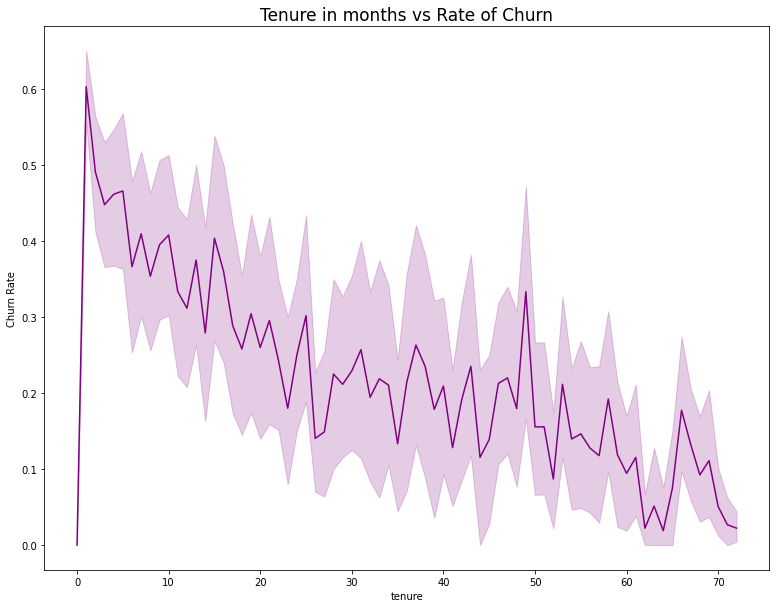

In [27]:
#function to plot rate of churn and tenure in months
ax = explore.lineplot_rate_of_churn_to_tenure_months(train)

In [28]:
train.tenure.value_counts(ascending=False)

1     403
72    224
2     165
3     134
4     117
     ... 
33     32
36     28
39     28
44     26
0      10
Name: tenure, Length: 73, dtype: int64

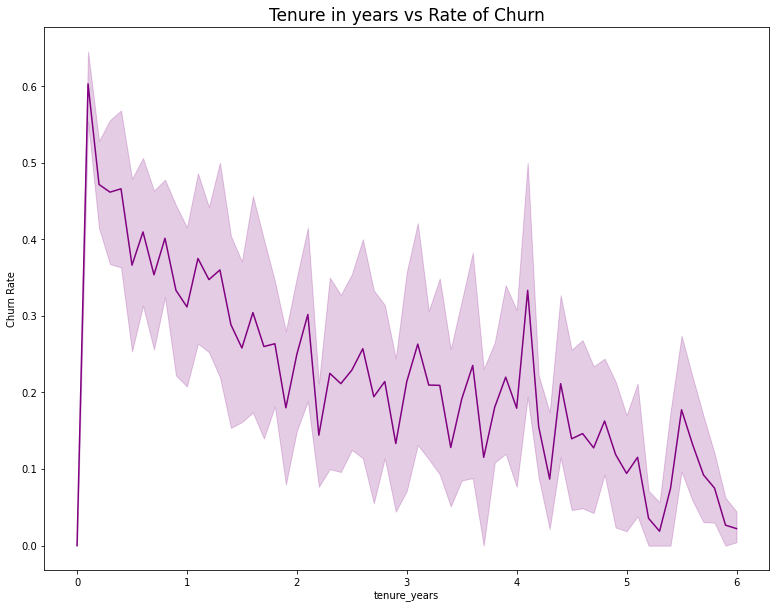

In [29]:
#function to plot rate of churn and tenure in years
explore.lineplot_rate_of_churn_to_tenure_years(train)

In [30]:
train.tenure_years.value_counts(ascending=False)

0.1    403
0.2    299
6.0    224
0.8    157
5.8    133
      ... 
2.6     35
3.6     34
3.0     28
3.7     26
0.0     10
Name: tenure_years, Length: 61, dtype: int64

In [31]:
ctab = pd.crosstab(train.churn, train.contract_type)
ctab

contract_type,Month-to-month,One year,Two year
churn,,,
No,1432,826,1046
Yes,1062,108,33


**Takeaways for tenure vs rate of churn:**

We see most customers are churning at lower tenures with a spike right around 4 years. Overall there is a downward trend as tenure increases. However this may be because most of our customers tenures are below 1 year

Below is a visualization of Churn Rates within each Contract Type

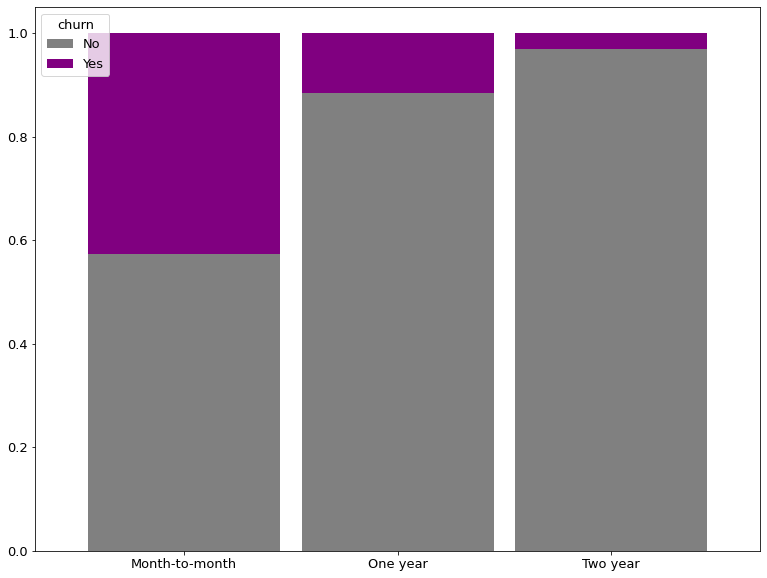

In [32]:
explore.stacked_barplot_for_churn_rates_by_contract(train)

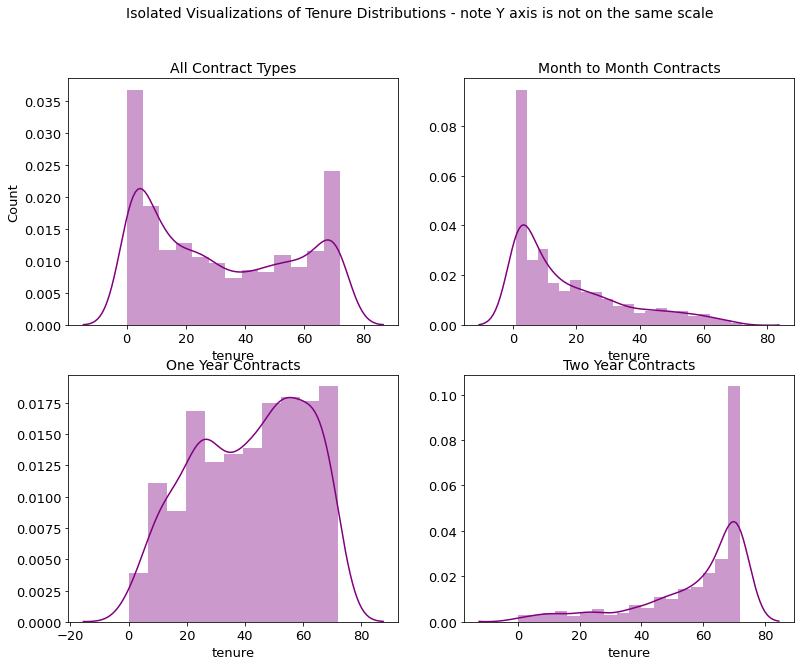

In [33]:
explore.isolated_tenure_distros(train)

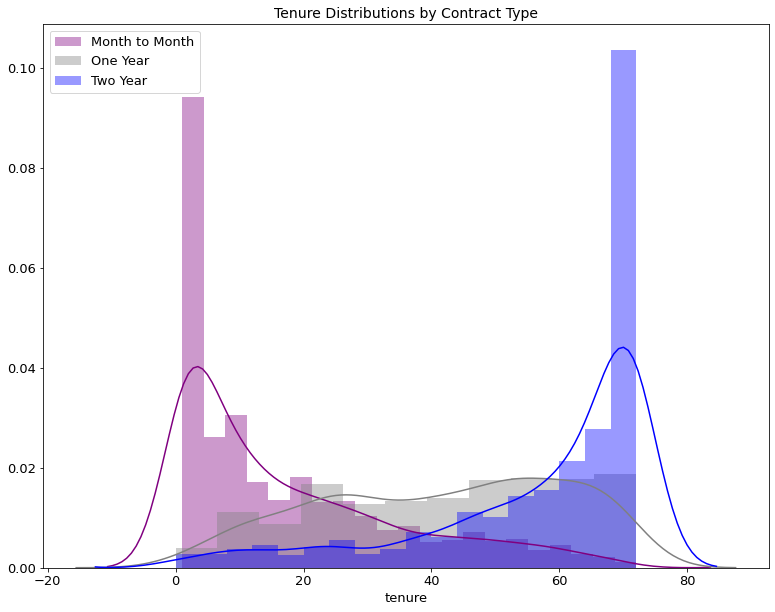

In [34]:
explore.tenure_distros_overlayed(train)

**Quick Takeaway**

- Far more customers who are on month to month contracts and they also have the highest churn rate which is sitting at approximately 43%, this is much higher than one year(approx. 12%) and two year(approx. 3%)
- Month to Month contracts are right skewed, Two Year Contracts are left skewed and one year contracts by comparison are normally distributed

**New Question:**

Why are customers choosing the Month to Month option? Are monthly rates lower?

**Explore monthly charges**

In [35]:
df = explore.stats_for_contract_types(train)
df

,Mean monthly charges,Median monthly charges,Max monthly charges,Min monthly charges,STD monthly charges
contract_type,,,,,
Month-to-month,66.105894,73.075,116.50,18.80,26.719017
One year,65.155407,67.275,118.60,18.25,31.871457
Two year,61.439574,64.700,118.75,18.55,34.469041


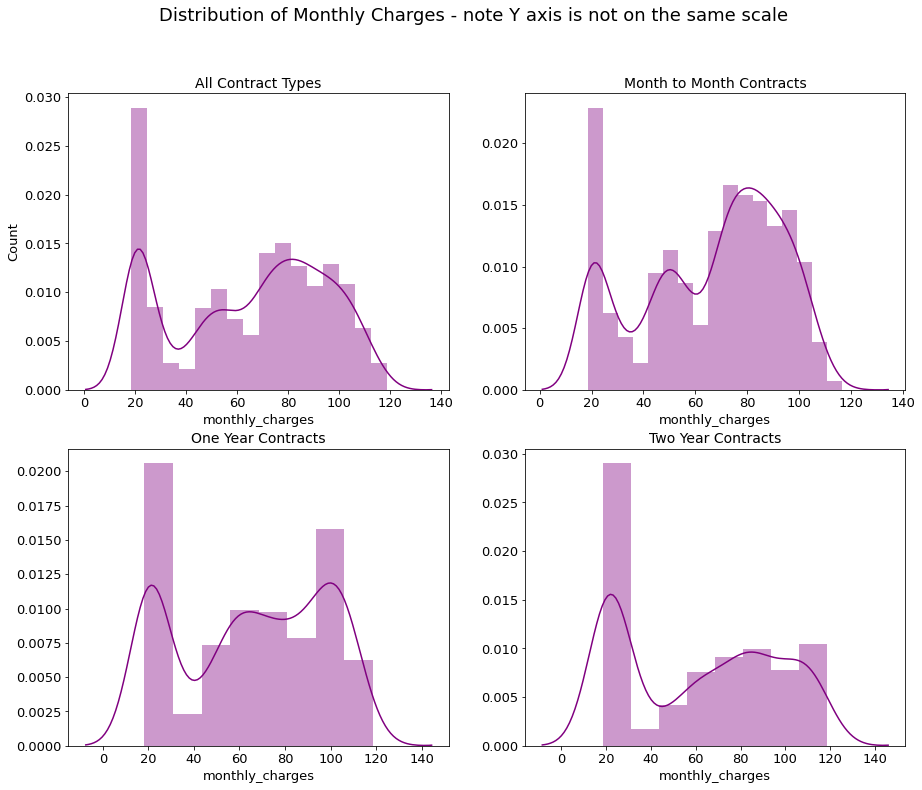

In [36]:
explore.monthly_charges_distros(train)

**Takeaways:**
- Customers with 2 year contracts are least likely to churn and month-to-month contracts most likely to churn.
- We should consider running some sort of incentive to convert monthly customers that we feel are potential customers to churn.
- Surprisingly there is not a clear difference between monthly charges and contract types

## Churn Rates at 12 months
Here we will compare each contract type at the 12 month marker

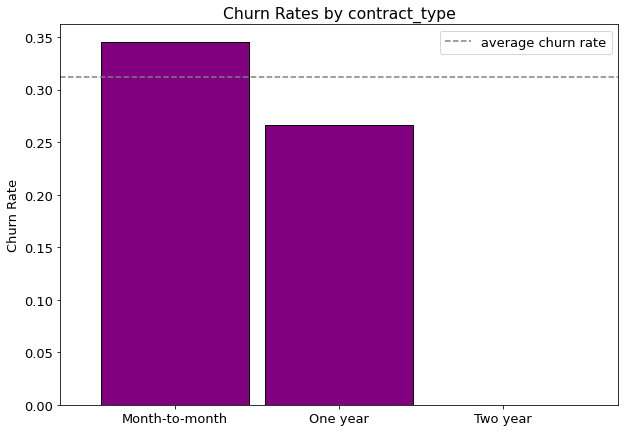

In [37]:
df_tenure_at_one_year = train[train.tenure == 12]
explore.plot_categorical_with_churn_rates(df_tenure_at_one_year, "contract_type")

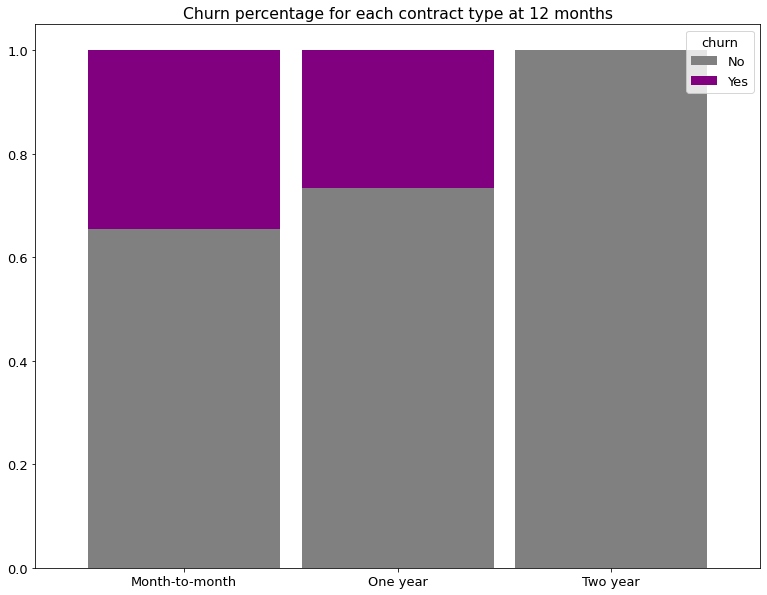

In [38]:
explore.churn_percentages_at_12_months(train)

**Question:**

If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

**Answer:**

- Overall customers on the month to month contract have a slightly higher churn rate. 
- The difference between the monthly contract and one year contracts is roughly 8%. 
- When we look into the churn rates within each subgroup we see:
    - roughly 45% of month-to-month customers are churning
    - roughly 25% of one-year contract are churning.

## Groupings VS Churn Rate

Here we will:
- explore all other factors that were not tested in our $Chi^2$ tests 
- make visualizations to help absorb our information
- Answer the question of what the drivers are behind churning 

**Correlations and quick stats**

In [39]:
#take a quick look at stats to see if anything jumps at us
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,tenure_years,phone_lines,partner_encoded,dependents_encoded,dependent_partner_grouping,contract_type_encoded,encoded_internet_service_type,churn_encoded,payment_type_encoded,online_security_encoded,tech_support_encoded,device_protection_encoded,online_backup_encoded
count,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000
mean,0.165742,31.942978,64.791779,2256.158076,2.662103,1.321722,0.475926,0.291103,0.767029,0.686044,0.867318,0.266918,1.586421,0.783892,0.786998,0.900599,0.901930
std,0.371890,24.718649,29.886761,2263.086693,2.058358,0.643776,0.499476,0.454321,0.809588,0.833278,0.735363,0.442398,1.061271,0.860629,0.861403,0.881766,0.881915
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,35.900000,374.250000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,70.300000,1387.450000,2.200000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,55.000000,89.650000,3772.575000,4.600000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,72.000000,118.750000,8684.800000,6.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000


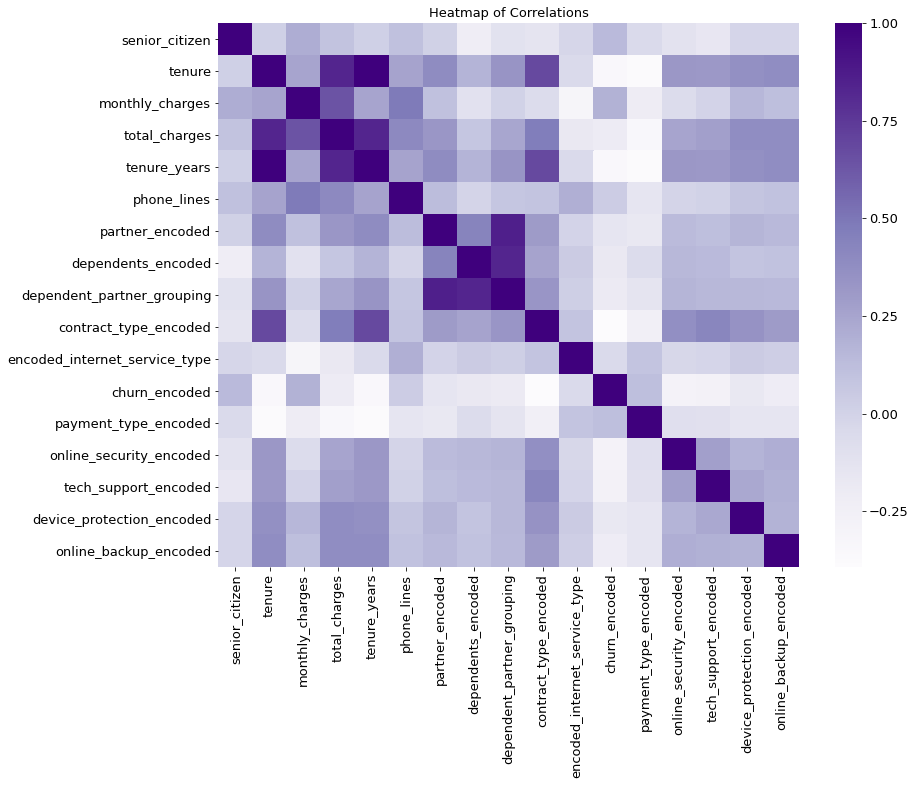

In [40]:
#take a look at correlations
explore.initial_corr_heatmap(train)

**Takeaways**
- mean for tenure is roughly 2 and a half years
- our max tenure is sitting at 6 years
- Because the correlation heatmap is so extensive it is difficult to get full understanding from it so we will run a correlation heatmap after the EDA and before modeling begins so we can whittle away features that are not useful

**Visualizations**

Here we will plot various features to see if we can find easily identifiable groups that are driving churn rates

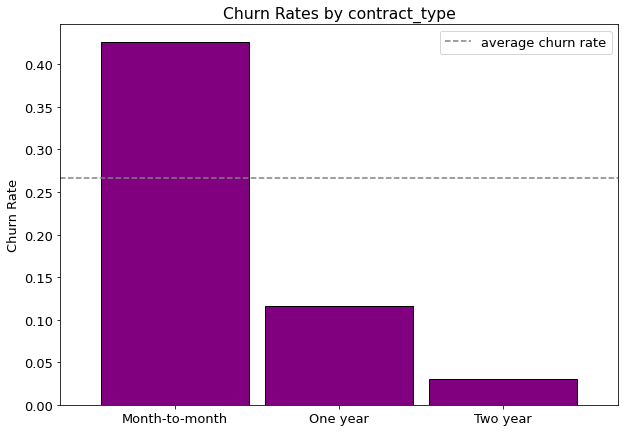

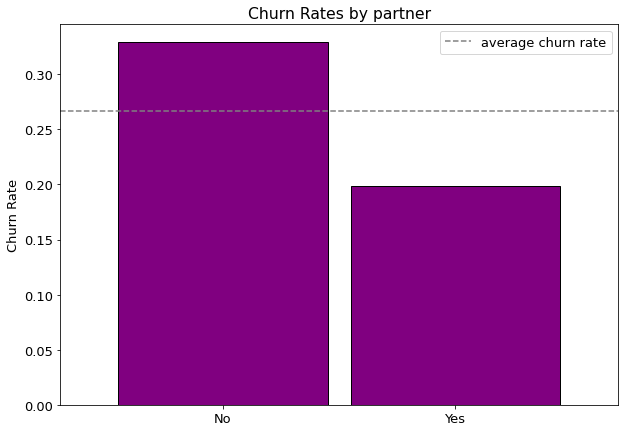

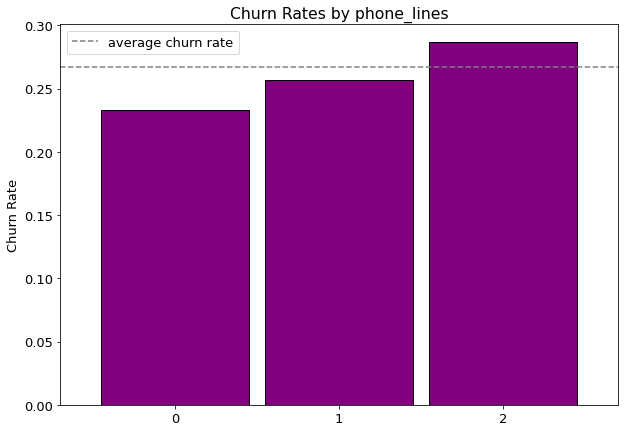

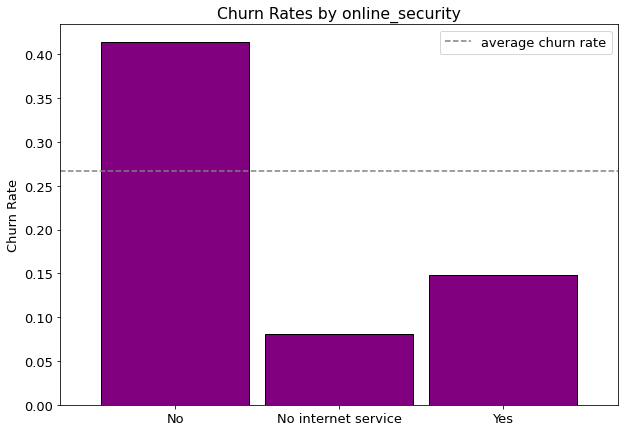

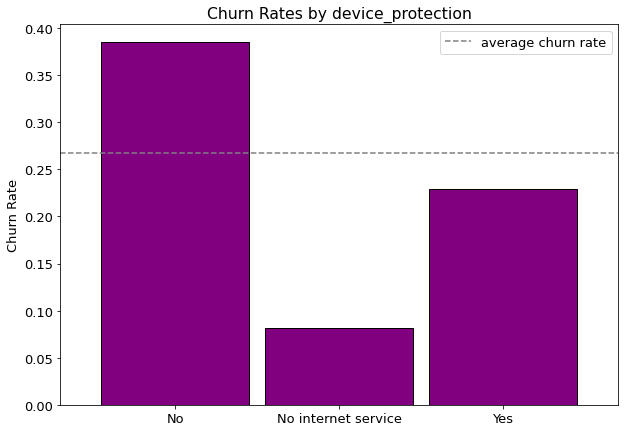

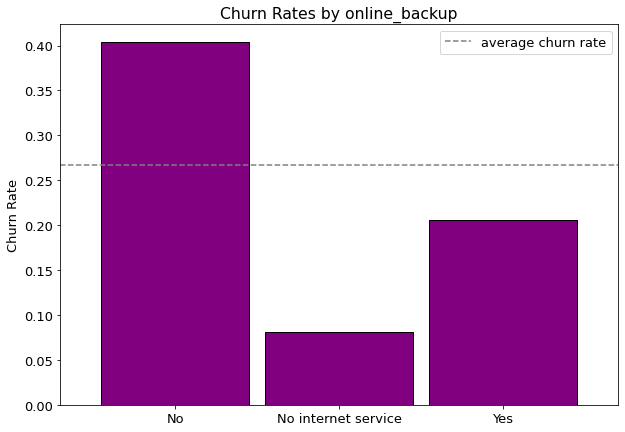

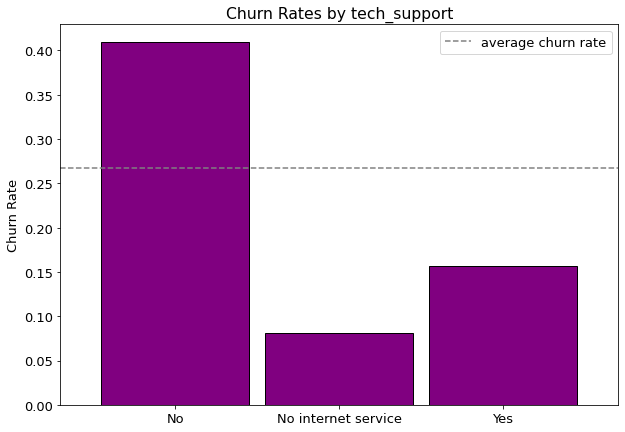

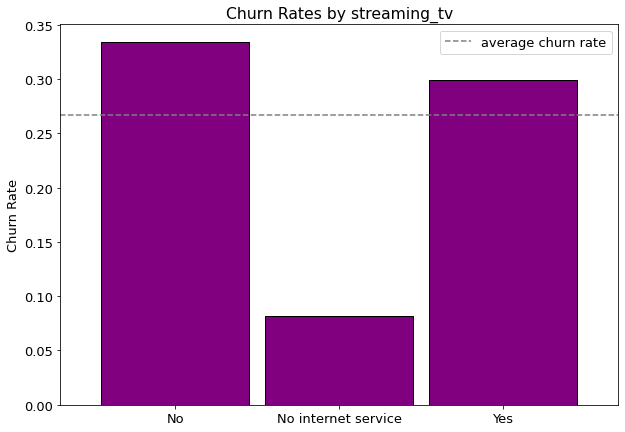

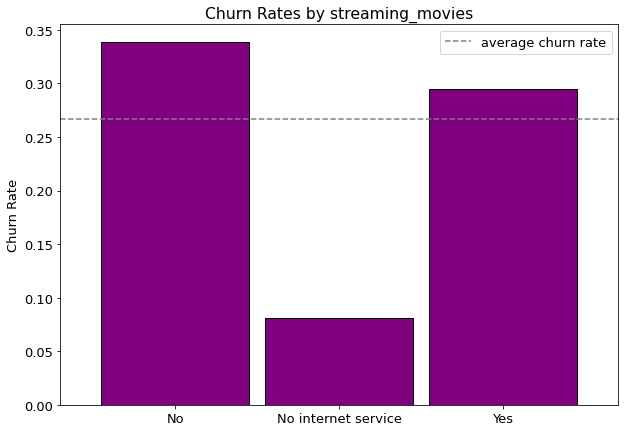

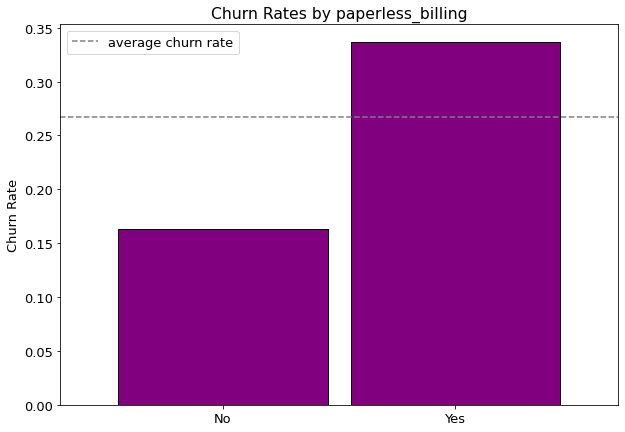

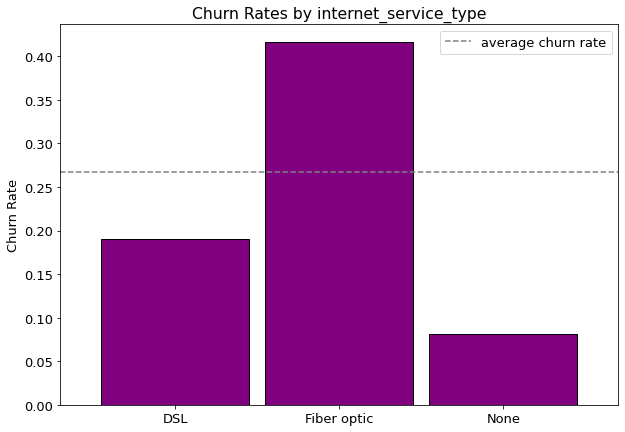

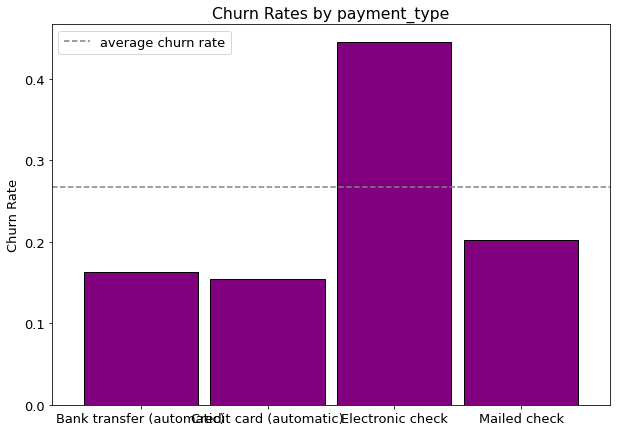

In [41]:
explore.plot_all_categoricals_with_churn_rates(train)

**Question Asked**:

Are there clear groupings where a customer is more likely to churn? What if you consider contract type? Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers? 2-year customers? Do you have any thoughts on what could be going on?

**Answers**:

Untested Findings:
- As predicted Month to Month customers seem to be more likely to churn
- Customers not receiving online security seem to be churning at a higher rate
- Customers not receiving device protection seem to be churning at a higher rate
- Customers not receiving online backup seem to be churning at a higher rate
- Customers who do not receive tech support seem to be churning at a higher rate
- Customers who receive paper bills seem to be more likely to churn
- Customers with Fiber Optics seem to be more likely to churn - this is surprising since this is considered a premium service.
- Customers who pay via electronic check seem to be more likely to churn

Tested Findings from our $Chi^2$
- Senior citizens are highly likely to churn
- Gender does not play a significant role in whether or not a customer will churn
- Customers with dependents are less likely to churn
    

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4507 entries, 1249 to 6958
Data columns (total 31 columns):
customer_id                      4507 non-null object
senior_citizen                   4507 non-null int64
partner                          4507 non-null object
dependents                       4507 non-null object
tenure                           4507 non-null int64
online_security                  4507 non-null object
online_backup                    4507 non-null object
device_protection                4507 non-null object
tech_support                     4507 non-null object
streaming_tv                     4507 non-null object
streaming_movies                 4507 non-null object
paperless_billing                4507 non-null object
monthly_charges                  4507 non-null float64
total_charges                    4507 non-null float64
churn                            4507 non-null object
contract_type                    4507 non-null object
internet_service_type     

Quick Correlation Heat Map for the above features only

In [43]:
df = train[["contract_type_encoded", "encoded_internet_service_type", "online_security_encoded", "online_backup_encoded","tech_support_encoded", "payment_type_encoded", "senior_citizen", "dependent_partner_grouping", "churn_encoded", "tenure"]]

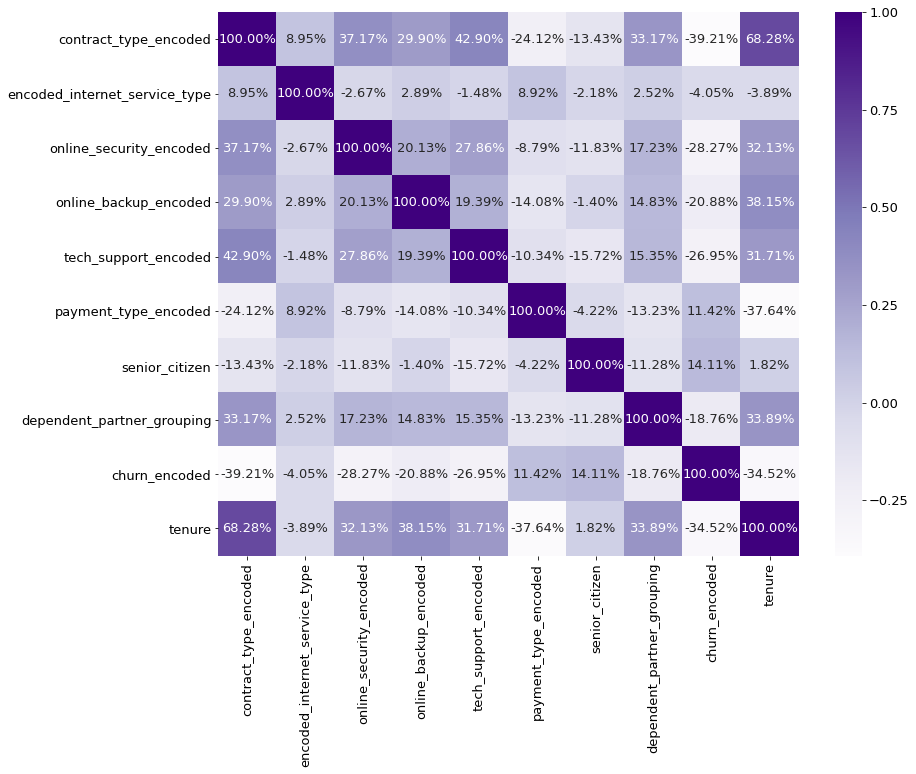

In [44]:
sns.heatmap(df.corr(), annot=True, cmap='Purples', fmt='.2%')

In [45]:
train.head(4)

,customer_id,senior_citizen,partner,dependents,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,...,dependents_encoded,dependent_partner_grouping,contract_type_encoded,encoded_internet_service_type,churn_encoded,payment_type_encoded,online_security_encoded,tech_support_encoded,device_protection_encoded,online_backup_encoded
1249,0484-FFVBJ,0,No,No,32,No,No,No,No,Yes,...,0,0,1,0,0,0,0,0,0,0
6265,6096-EGVTU,0,Yes,Yes,64,No internet service,No internet service,No internet service,No internet service,No internet service,...,1,2,1,2,0,3,1,1,1,1
3772,6178-KFNHS,0,No,Yes,12,Yes,No,No,No,No,...,1,1,0,1,1,2,2,0,0,0
3391,4529-CKBCL,0,No,No,2,No,No,No,No,Yes,...,0,0,0,1,1,2,0,0,0,0


**Takeaways**
- We see that online security ,online backup and tech support are closely related so we will create a new feature with those combined into one


## Price Thresholds

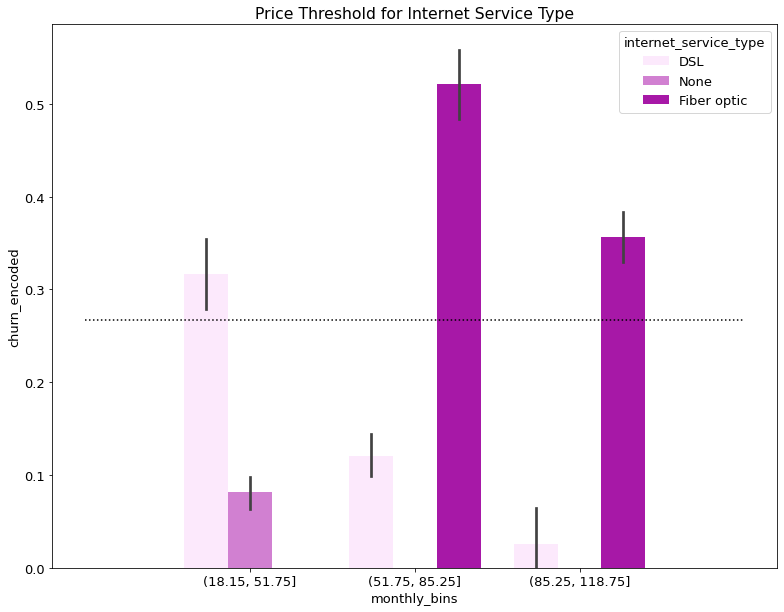

In [46]:
explore.price_threshold_internet_services(train)

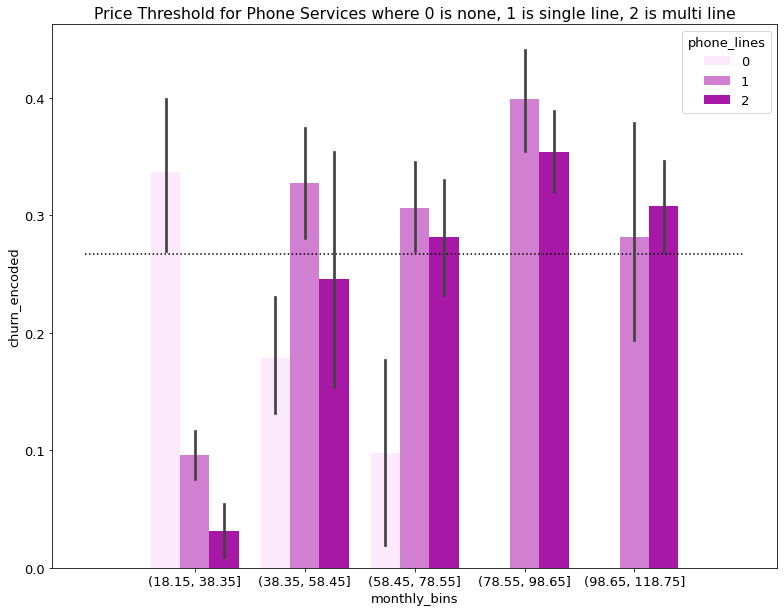

In [47]:
explore.price_threshold_phone_lines(train)

**Question Asked:**

Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

**Answer**

- At around \$40 customers with a single and multi phone line seem more likely to start churning
- At around $80 customers with Fiber Optic Internet service seem more likely to churn

# Modeling

Because we are trying to predict the customers that will churn, our positive variable will be churn or in our case 1.

**Possible Outcomes:**

TP: Predict that a customer will churn and they do

TN: Predict that a customer will not churn and they do not

FP: Predict that a customer will churn but they do not

FN: Predict that a customer will not churn but they do

**In our Case:**
Since we are trying to identify customers that will churn we want to minimize our FN but we also do not want to assume all customers will churn so we will start with overall accuracy scores, followed by recall scores to select our top model

## Baseline Model

Our baseline is going to be predicting all customers will not churn because that is the most common value. The baseline will help us evaluate how our models are doing compared to assuming all customers will stay and not churn

- We are going to create a variable that stores the mean of the average monthly charge so we can find out how much we are loosing per month with our predictions

In [48]:
# dataframe for our y_train
y_train = train.churn_encoded

In [49]:
#variable for mean average
avg_monthly_charge = train.monthly_charges.mean()
avg_monthly_charge

64.79177945418236

In [50]:
#I'm going to create a new dataframe to hold all our predicted values from all our models
evaluations = pd.DataFrame({"actual": y_train})
evaluations["baseline"] = 0

In [51]:
matrix = pd.crosstab(evaluations.actual, evaluations.baseline)
matrix

baseline,0
actual,
0,3304
1,1203


In [52]:
#calcualte accuracy for baseline
baseline_accuracy = (evaluations.baseline == evaluations.actual).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.31%


In [53]:
basline_loss = 1203 * avg_monthly_charge

In [54]:
print(f"Our baseline model is costing us roughly ${basline_loss:2,.2f} a month, which is what we are currently loosing since we do not have a model in place.")

Our baseline model is costing us roughly $77,944.51 a month, which is what we are currently loosing since we do not have a model in place.


In [ ]:
#code for final graph
model_results.Recall_Score = model_results.Recall_Score * 100
model_results.Accuracy_Score = model_results.Accuracy_Score * 100

plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)
model_results.groupby("Model_Type").sum().plot.bar(color=["#7870d5","#216cdb"], width=.9, )
plt.hlines(73, *plt.xlim(), ls='--', color='grey', label='Baseline Accuracy rate' )
plt.xticks(rotation=0)
plt.title("Accuracy and Recall Rates for each Model")
# plt.legend("")